# MS017 Preprocess
06/18/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS017'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Data

In [5]:
edf_files = glob(f'{neural_dir}/MS017/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


In [6]:
mne_data

<RawEDF | MS017_SWB.edf, 276 x 2282048 (2228.6 s), ~4.69 GB, data loaded>

In [7]:
mne_data.ch_names

['LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LHplT1',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LHplT10',
 'LalpS1',
 'LalpS2',
 'LalpS3',
 'LalpS4',
 'LalpS5',
 'LalpS6',
 'LalpS7',
 'LalpS8',
 'LalpS9',
 'LalpS10',
 'LalpS11',
 'LalpS12',
 'LalpS13',
 'LalpS14',
 'LmlBr1',
 'LmlBr2',
 'LmlBr3',
 'LmlBr4',
 'LmlBr5',
 'LmlBr6',
 'LpCWr1',
 'LpCWr2',
 'LpCWr3',
 'LpCWr4',
 'LpCWr5',
 'LpCWr6',
 'LpCWr7',
 'LpCWr8',
 'LpCWr9',
 'LpCWr10',
 'LpCWr11',
 'LpCWr12',
 'LllT1',
 'LllT2',
 'LllT3',
 'LllT4',
 'LllT5',
 'LllT6',
 'LllT7',
 'LllT8',
 'Lpl

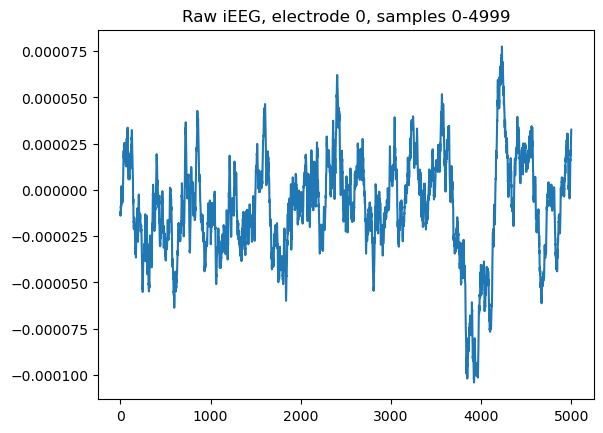

In [8]:
# Sanity check one channel data
plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Examine photodiode

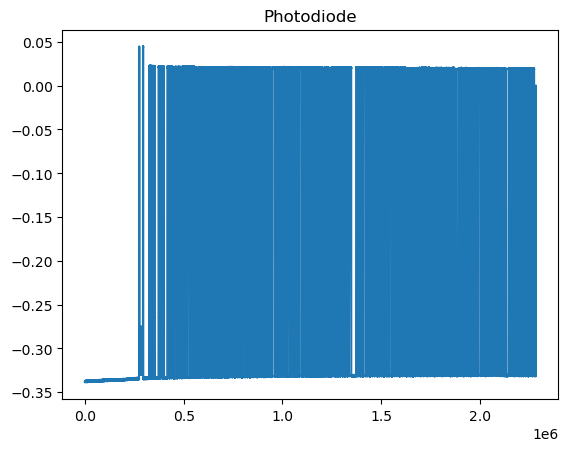

In [10]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("Research")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

### Import Anat Recon Info - check all elecs are present in data + recon sheet


### Fix edf channel names

In [11]:
# Load the electrode localization data
ms017_anat_file = glob(f'{anat_dir}/MS017_labels.csv')[0]
elec_locs = pd.read_csv(ms017_anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

NMMlabel BN246label          x          y          z      mni_x  \
0      umOlF     A11m_L  -5.954451  58.308871  -5.446998  -5.251752   
1     uLAgIT    mAmyg_L -17.951753  11.146713 -15.841007 -18.630204   
2     LaCaS1    A32sg_L  -5.954451  37.525547   2.948164  -5.375178   
3    LaCaS10      A9l_L -10.353462  45.119454  48.921668  -9.051641   
4    LaCaS11    Unknown -10.753372  46.318492  52.119825  -9.423595   
..       ...        ...        ...        ...        ...        ...   
105   LTPlT4     A21r_L -36.347618  23.536772 -25.835248 -38.966744   
106   LTPlT5     A21r_L -41.146539  23.137092 -25.035708 -44.119363   
107   LTPlT6     A21r_L -46.345370  22.737413 -23.836399 -49.685882   
108   LTPlT7     A21r_L -50.744381  22.737413 -22.637091 -54.349179   
109   LTPlT8    Unknown -56.743032  22.737413 -21.437782 -60.760144   

         mni_y      mni_z       gm                                 NMM  \
0    52.377382 -19.502634     Gray               Left GRe gyrus rectus   
1    -2.284212 -22.591126     Gray                       Left Amygdala   
2    31.113916  -6.133334     Gray  Left ACgG anterior cingulate gyrus   
3    49.423312  46.098305     Gray     Left SFG superior frontal gyrus   
4    51.602239  49.768326  Unknown                             Unknown   
..         ...        ...      ...                                 ...   
105   9.549138 -35.666432    White              Left TMP temporal pole   
106   9.465391 -34.533635     Gray              Left TMP temporal pole   
107   9.485142 -32.884898     Gray              Left TMP temporal pole   
108   9.952847 -31.341105     Gray              Left TMP temporal pole   
109  10.562419 -29.785736  Unknown                             Unknown   

              Anat                  AnatMacro    BN246  \
0         Area Fo1             L Rectal Gyrus    L OrG   
1    Amygdala (LB)                 L Amygdala   L Amyg   
2         Area s24                      L ACC     L CG   
3          Unknown    L Superior Medial Gyrus    L SFG   
4          Unknown    L Superior Medial Gyrus  Unknown   
..             ...                        ...      ...   
105        Unknown  L Inferior Temporal Gyrus    L MTG   
106        Unknown  L Inferior Temporal Gyrus    L MTG   
107        Unknown     L Medial Temporal Pole    L MTG   
108        Unknown     L Medial Temporal Pole    L MTG   
109        Unknown                    Unknown  Unknown   

                                    YBA_1  \
0                Left frontal orbital 2 A   
1                  Left amygdala inferior   
2                  Left cingulate gyrus D   
3         Left superior frontal gyrus 2 C   
4         Left superior frontal gyrus 2 C   
..                                    ...   
105  Left superior middle temporal pole D   
106  Left superior middle temporal pole D   
107  Left superior middle temporal pole D   
108  Left superior middle temporal pole D   
109                               Unknown   

                       Manual Examination Notes  
0                                      WM   NaN  
1                                     NaN   NaN  
2                                      WM   NaN  
3                                     NaN   NaN  
4                                     OOB   NaN  
..                                    ...   ...  
105                                    WM   NaN  
106  Left inferior middle temporal pole C   NaN  
107                                   NaN   NaN  
108                                   NaN   NaN  
109                                   OOB   NaN  

[110 rows x 16 columns]

In [13]:
list(elec_locs.NMMlabel)

['umOlF',
 'uLAgIT',
 'LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LalpS1',
 'LalpS10',
 'LalpS11',
 'LalpS12',
 'LalpS13',
 'LalpS14',
 'LalpS2',
 'LalpS3',
 'LalpS4',
 'LalpS5',
 'LalpS6',
 'LalpS7',
 'LalpS8',
 'LalpS9',
 'LHplT1',
 'LHplT10',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LllT1',
 'LllT2',
 'LllT3',
 'LllT4',
 'LllT5',
 'LllT6',
 'LllT7',
 'LllT8',
 'LmCmS1',
 'LmCmS10',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmlBr1',
 'LmlBr2',
 'LmlBr3',
 'LmlBr4',
 'LmlBr5',
 'LmlBr6',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LpCWr1',
 'LpCWr10',
 'LpCWr11',
 'LpCWr12',
 'LpCWr2',
 'LpCWr3',
 'LpCWr4',
 'LpCWr5',
 'LpCWr6',
 'LpCWr7',
 'LpCW

In [14]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.NMMlabel)


In [15]:
unmatched_names

['ulagit', 'umolf']

In [16]:
unmatched_seeg  #make sure there are no unmatched names

[]

In [17]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [18]:
new_name_dict

{'LmOlF1': 'lmolf1',
 'LmOlF2': 'lmolf2',
 'LmOlF3': 'lmolf3',
 'LmOlF4': 'lmolf4',
 'LmOlF5': 'lmolf5',
 'LmOlF6': 'lmolf6',
 'LmOlF7': 'lmolf7',
 'LmOlF8': 'lmolf8',
 'LmOlF9': 'lmolf9',
 'LaCaS1': 'lacas1',
 'LaCaS2': 'lacas2',
 'LaCaS3': 'lacas3',
 'LaCaS4': 'lacas4',
 'LaCaS5': 'lacas5',
 'LaCaS6': 'lacas6',
 'LaCaS7': 'lacas7',
 'LaCaS8': 'lacas8',
 'LaCaS9': 'lacas9',
 'LaCaS10': 'lacas10',
 'LaCaS11': 'lacas11',
 'LaCaS12': 'lacas12',
 'LmCmS1': 'lmcms1',
 'LmCmS2': 'lmcms2',
 'LmCmS3': 'lmcms3',
 'LmCmS4': 'lmcms4',
 'LmCmS5': 'lmcms5',
 'LmCmS6': 'lmcms6',
 'LmCmS7': 'lmcms7',
 'LmCmS8': 'lmcms8',
 'LmCmS9': 'lmcms9',
 'LmCmS10': 'lmcms10',
 'LAglT1': 'laglt1',
 'LAglT2': 'laglt2',
 'LAglT3': 'laglt3',
 'LAglT4': 'laglt4',
 'LAglT5': 'laglt5',
 'LAglT6': 'laglt6',
 'LAglT7': 'laglt7',
 'LAglT8': 'laglt8',
 'LAglT9': 'laglt9',
 'LHplT1': 'lhplt1',
 'LHplT2': 'lhplt2',
 'LHplT3': 'lhplt3',
 'LHplT4': 'lhplt4',
 'LHplT5': 'lhplt5',
 'LHplT6': 'lhplt6',
 'LHplT7': 'lhplt7',
 'LHp

In [19]:
# Rename the mne data according to the localization data
mne_data.rename_channels(new_name_dict)

<RawEDF | MS017_SWB.edf, 276 x 2282048 (2228.6 s), ~4.69 GB, data loaded>

In [20]:
unmatched_seeg

[]

In [21]:
anat_names = list(elec_locs.NMMlabel.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c109', 'c110', 'c111', 'c112', 'c113', 'c114', 'c115', 'c116', 'c117', 'c118', 'c119', 'c120', 'c121', 'c122', 'c123', 'c124', 'c125', 'c126', 'c127', 'c128', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'abs1', 'abs2', 'chest1', 'chest2', 'c154', 'c155', 'c156', 'c157', 'c158', 'c159', 'c160', 'c161', 'c162', 'c163', 'c164', 'c165', 'c166', 'c167', 'c168', 'c169', 'c170', 'c171', 'c172', 'c173', 'c174', 'c175', 'c176', 'c177', 'c178', 'c179', 'c180', 'c181', 'c182', 'c183', 'c184', 'c185', 'c186', 'c187', 'c188', 'c189', 'c190', 'c191', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237',

In [22]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 108 left & 1 right sEEG electrodes
We have a total of 109 sEEG electrodes


In [25]:
list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['research'])) #list of non seeg/photodiode channels

['c229',
 'c187',
 'c112',
 'c195',
 'c215',
 'c211',
 'c256',
 'c247',
 'c239',
 'dc12',
 'f7',
 'f3',
 'c225',
 'c173',
 'c172',
 'dc10',
 'c119',
 'c156',
 'c222',
 'c248',
 'p3',
 'dc4',
 'c186',
 't3',
 'c165',
 'dc15',
 'c161',
 'chest1',
 'c118',
 'fp2',
 'c236',
 'c111',
 'c190',
 'chest2',
 'c206',
 'c167',
 't5',
 'dc16',
 'osat',
 'c184',
 'c212',
 'dc2',
 'ekg2',
 'c169',
 'c181',
 'c242',
 'c194',
 'c199',
 'c252',
 'c116',
 'c155',
 'c122',
 'dc7',
 'c231',
 'c162',
 'c178',
 'c183',
 'c213',
 'c157',
 'c221',
 'c171',
 'dc9',
 'dc11',
 'c193',
 'c192',
 'c128',
 'c223',
 'c217',
 'c176',
 'dc14',
 'f4',
 'c197',
 'c160',
 'c188',
 'dc5',
 'c226',
 'c201',
 'c189',
 'c123',
 'c218',
 'c230',
 'c120',
 'abs2',
 'c227',
 'cz',
 'p4',
 'c233',
 'c177',
 'dc8',
 'c202',
 'c4',
 'c115',
 'c164',
 'c254',
 'pr',
 'pleth',
 'ekg1',
 'c117',
 'c253',
 'c114',
 'c251',
 'c113',
 'c243',
 'dc3',
 'c205',
 'dc13',
 'c220',
 'c238',
 'c168',
 'c127',
 'c179',
 'c121',
 'c210',
 'c216

In [26]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['research']))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs + 1 (photodiode)

<RawEDF | MS017_SWB.edf, 109 x 2282048 (2228.6 s), ~1.85 GB, data loaded>

In [41]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
trig_mapping_dict = {'research':'stim'} #stim stands for stimulus
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawEDF | MS017_SWB.edf, 109 x 1141024 (2228.6 s), ~949.0 MB, data loaded>

In [43]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.NMMlabel, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS017_SWB.edf, 109 x 1141024 (2228.6 s), ~949.0 MB, data loaded>

### Notch filter line noise

In [44]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    2.5s finished


<RawEDF | MS017_SWB.edf, 109 x 1141024 (2228.6 s), ~949.0 MB, data loaded>

### Resampling Data

In [45]:
#resampling if patient is not sampled at 512
resample_sr = 512
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 109 out of 109 | elapsed:    5.1s finished


<RawEDF | MS017_SWB.edf, 109 x 1141024 (2228.6 s), ~949.0 MB, data loaded>

### Save out photodiode data
Note: this is after filtering out line noise and resampling

In [46]:
mne_data.save(f'{neural_dir}/MS017/photodiode.fif', picks='research', overwrite=True)

### Detect bad channels - detect_bad_elecs function auto detects, then we validate manually 

In [47]:
#make_mne function auto-detects bad electrodes. I want to compare auto vs manual ictal detection

bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #worked perfectly for this pt besides photodiode
mne_data.info['bads'] = bads

In [53]:
bads #bads picked up research? - manually remove
bads = bads[:-1]
bads

['lalps13', 'lmcms10', 'lmcms2', 'lmolf9', 'lpcwr7', 'lplsp10']

In [54]:
mne_data.info['bads'] = bads

In [55]:
mne_data.info

<Info | 10 non-empty values
 bads: 6 items (lalps13, lmcms10, lmcms2, lmolf9, lpcwr7, lplsp10)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 108 sEEG, 1 Stimulus
 custom_ref_applied: False
 dig: 108 items (108 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2001-01-01 15:28:29 UTC
 nchan: 109
 projs: []
 sfreq: 512.0 Hz
>

In [56]:
ch_names = list(elec_locs.NMMlabel.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [57]:
probe_names

array(['lacas', 'laglt', 'lalps', 'lhplt', 'lllt', 'lmcms', 'lmlbr',
       'lmolf', 'lpcwr', 'lplsp', 'ltplt', 'ulagit', 'umolf'], dtype='<U6')

In [58]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [59]:
probe_ch_counts

{'lacas': 12,
 'laglt': 9,
 'lalps': 14,
 'lhplt': 10,
 'lllt': 8,
 'lmcms': 10,
 'lmlbr': 6,
 'lmolf': 9,
 'lpcwr': 12,
 'lplsp': 10,
 'ltplt': 8,
 'ulagit': 1,
 'umolf': 1}

<IPython.core.display.Javascript object>


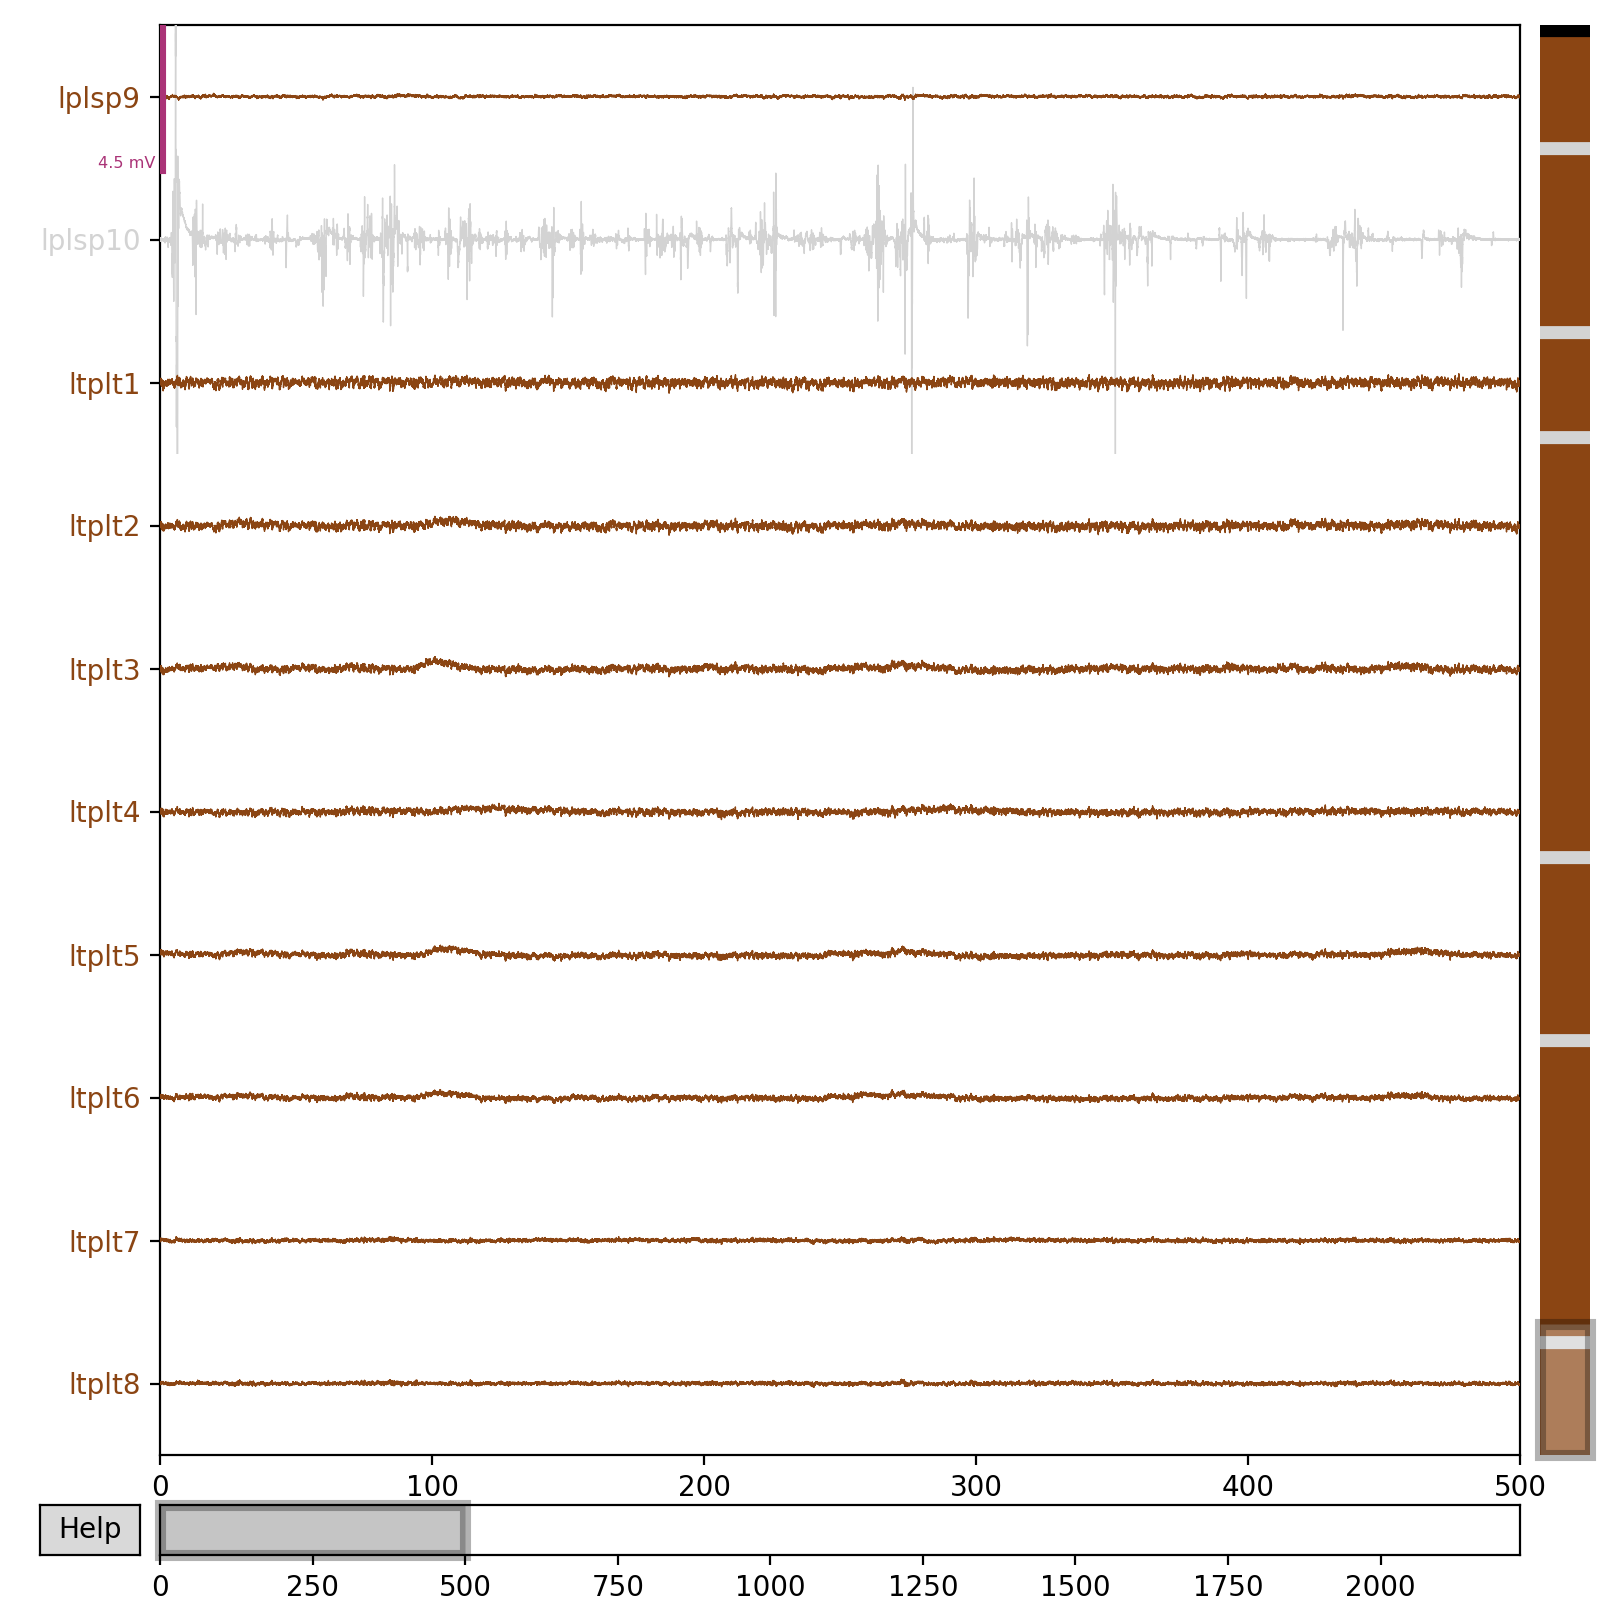

<IPython.core.display.Javascript object>


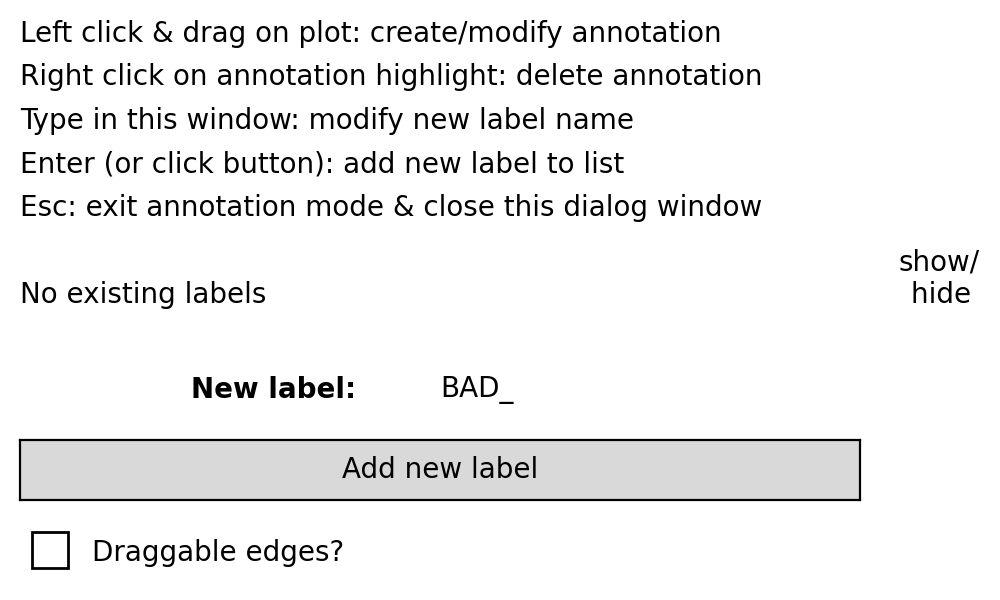

In [60]:
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=500, n_channels=10, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [61]:
mne_data.info['bads']

['lalps13', 'lmcms10', 'lmcms2', 'lmolf9', 'lpcwr7', 'lplsp10', 'research']

<IPython.core.display.Javascript object>


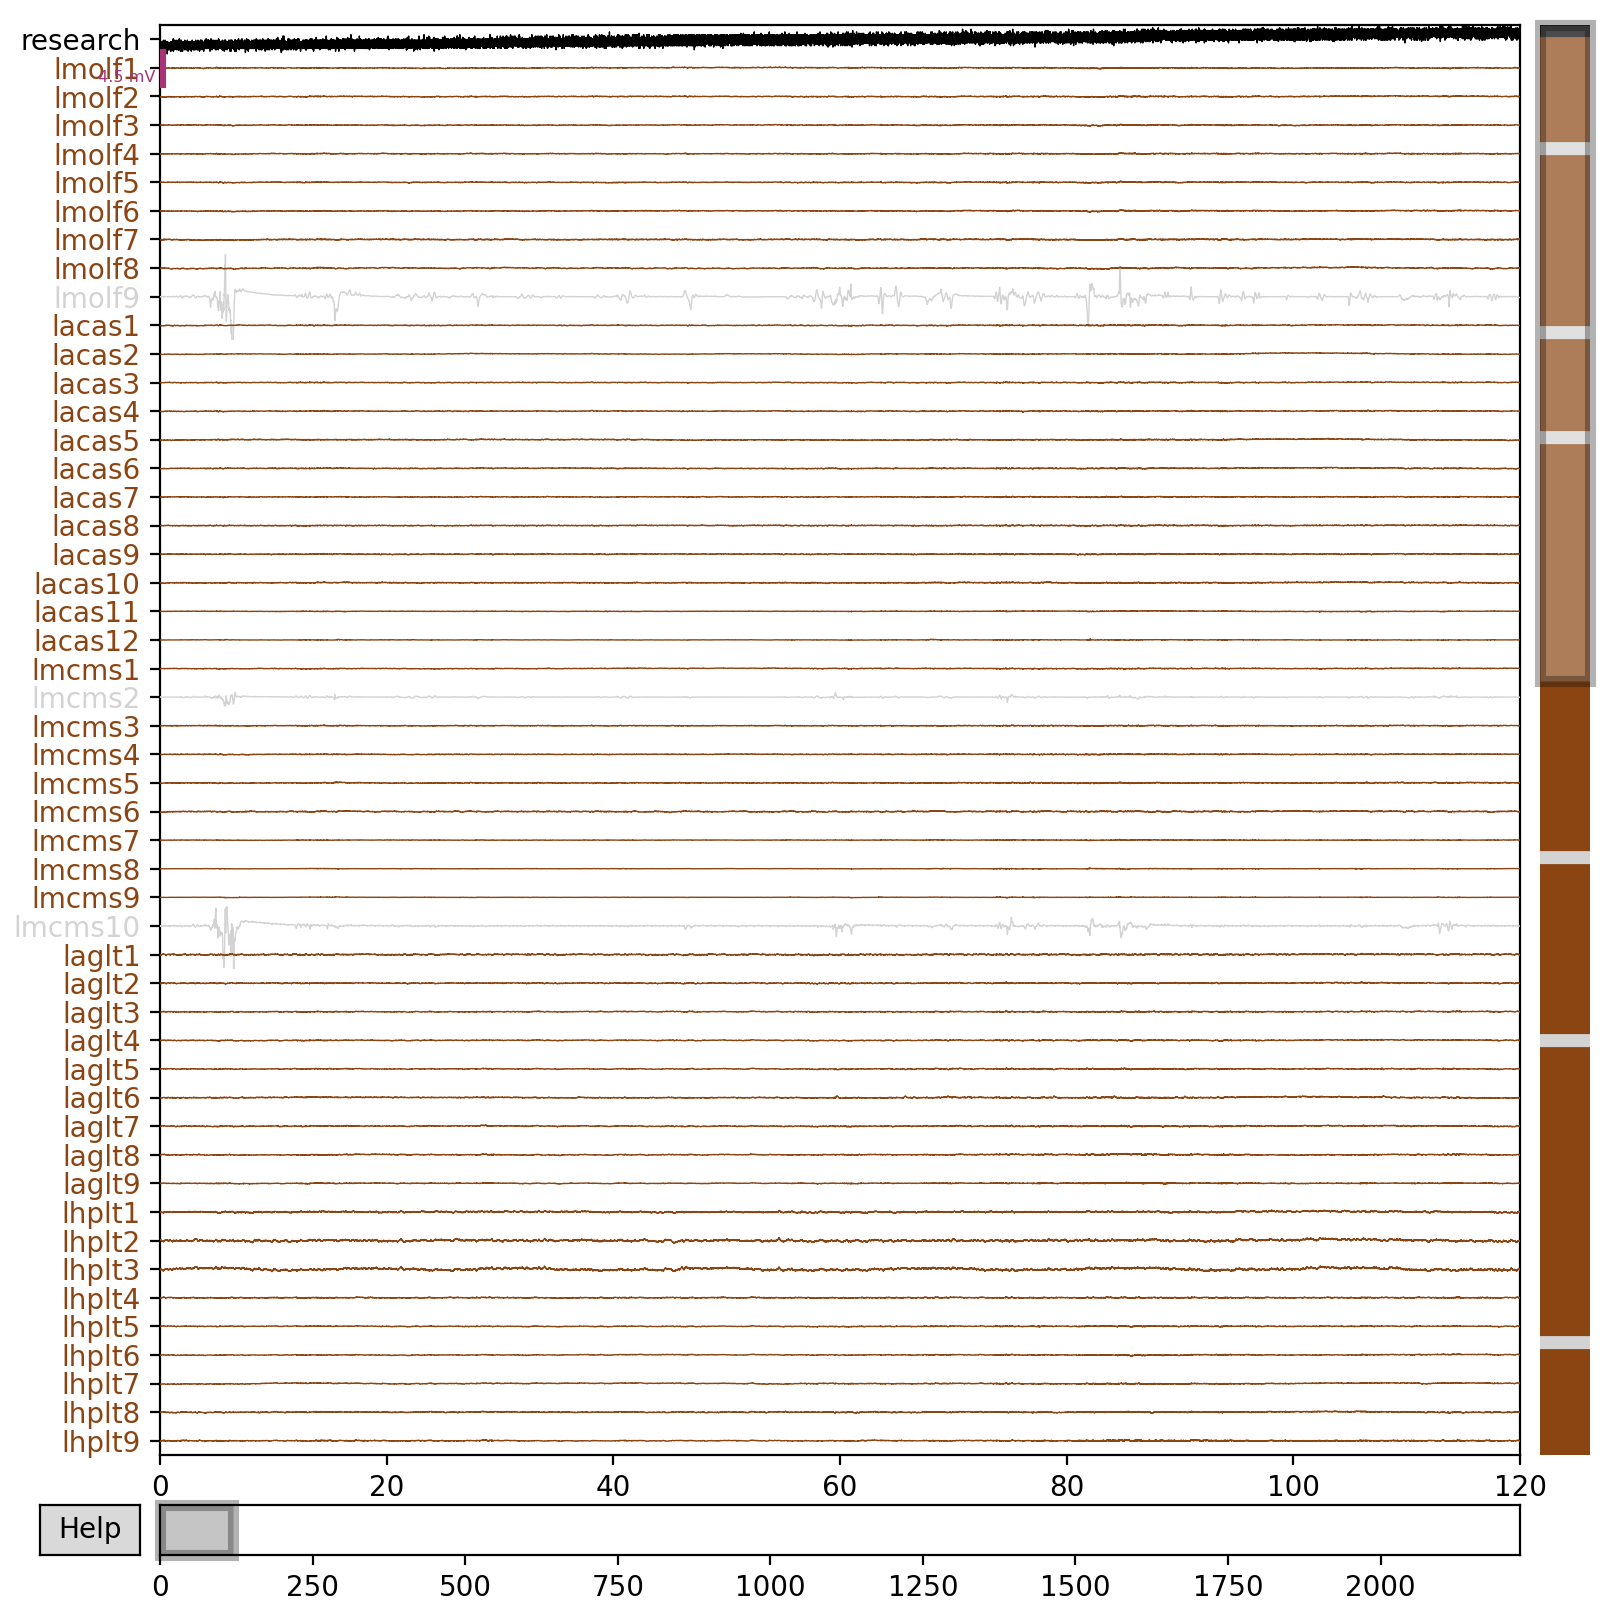

<IPython.core.display.Javascript object>


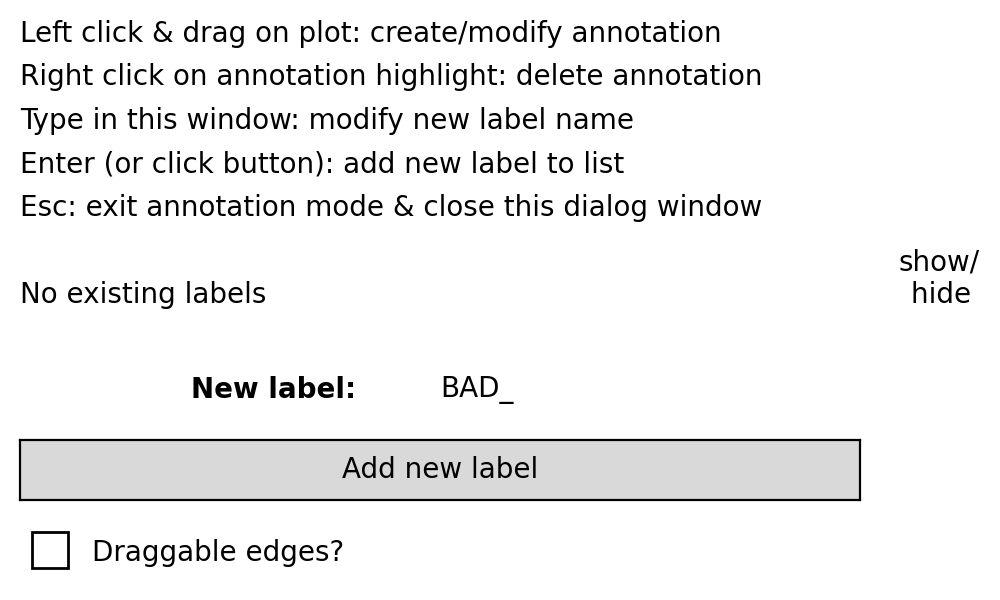

In [62]:
%matplotlib notebook
fig = mne_data.plot(start=0, duration=120, n_channels=50, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [63]:
mne_data.info['bads'] 

['lalps13', 'lmcms10', 'lmcms2', 'lmolf9', 'lpcwr7', 'lplsp10']

In [64]:
#set bad channel info 
ms017_bad_ch = ['lalps13', 'lmcms10', 'lmcms2', 'lmolf9', 'lpcwr7', 'lplsp10']


In [83]:
len(ms017_bad_ch)

40

In [65]:
#manually set bads because doing it in the plot is too buggy
mne_data.info['bads'] = ms017_bad_ch 

In [66]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 6 items (lalps13, lmcms10, lmcms2, lmolf9, lpcwr7, lplsp10)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 108 sEEG, 1 Stimulus
 custom_ref_applied: False
 dig: 108 items (108 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2001-01-01 15:28:29 UTC
 nchan: 109
 projs: []
 sfreq: 512.0 Hz
>

In [67]:
mne_data.info['bads'] #more sanity checking

['lalps13', 'lmcms10', 'lmcms2', 'lmolf9', 'lpcwr7', 'lplsp10']

### Rereference data to wm electrodes

In [68]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=ms017_anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site = 'MSSM')

In [69]:
oob_channels

['lacas11',
 'lacas12',
 'lalps14',
 'lllt8',
 'lmcms10',
 'lmcms9',
 'lmlbr5',
 'lmlbr6',
 'ltplt8']

In [70]:
#need to distinguish between wm channels and oob channels 

#add oob channels to bad channels list
ms017_bad_ch = ms017_bad_ch + oob_channels
ms017_bad_ch = list(np.unique(ms017_bad_ch))
mne_data.info['bads'] = ms017_bad_ch

In [71]:
mne_data.info['bads'] #needed to rerun plotting function to find this again?

['lacas11',
 'lacas12',
 'lalps13',
 'lalps14',
 'lllt8',
 'lmcms10',
 'lmcms2',
 'lmcms9',
 'lmlbr5',
 'lmlbr6',
 'lmolf9',
 'lpcwr7',
 'lplsp10',
 'ltplt8']

In [72]:
mne_data_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [73]:
mne_data_reref

<RawEDF | MS017_SWB.edf, 87 x 1141024 (2228.6 s), ~757.5 MB, data loaded>

### Save cleaned continuous data

In [74]:
mne_data.save(f'{neural_dir}/MS017/lfp_data.fif',overwrite=True)

In [75]:
mne_data_reref.save(f'{neural_dir}/MS017/wm_ref_ieeg.fif',overwrite=True)